In [13]:
# Import libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
! pip install category_encoders
from category_encoders import TargetEncoder
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import os

In [14]:
# Load data
filename = '/content/claims_data.csv'
df = pd.read_csv(filename)

# Drop rows with missing or invalid target values
df = df[df['loss'].notna() & (df['loss'] >= 0)]

# Separate features and target
X = df.drop(columns=['loss'])
y = df['loss']

# Identify categorical columns
cat_cols = X.select_dtypes(include=['object']).columns.tolist()

# Target encode categorical columns
if cat_cols:
    te = TargetEncoder(cols=cat_cols)
    X = te.fit_transform(X, y)

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Define Baseline XGBoost model
model = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1,
    random_state=42,
    objective='reg:squarederror',
    eval_metric='mae'
)

# Fit model
model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=False
)

# Predict
y_pred = model.predict(X_test)

# Evaluate
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae  = mean_absolute_error(y_test, y_pred)

print(f"\nFinal RMSE: {rmse:.4f}")
print(f"Final MAE:  {mae:.4f}")


Final RMSE: 1844.1422
Final MAE:  1171.9867



Top 20 Most Important Features:
cat80     0.160469
cat57     0.089896
cat79     0.059319
cat12     0.050581
cat113    0.026266
cat101    0.022149
cat81     0.021944
cat72     0.019471
cont2     0.019143
cat108    0.019081
cat87     0.016729
cat53     0.014961
cat109    0.013986
cont7     0.013496
cont12    0.012846
cat1      0.012572
cat116    0.011582
cat111    0.011480
cat103    0.011412
cat100    0.010674
dtype: float32


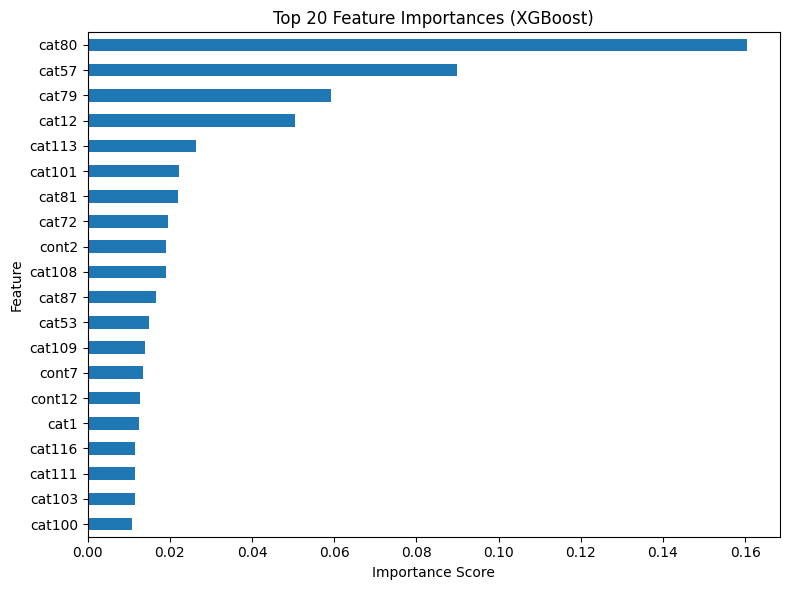

In [15]:
# Feature importance (Top 20)
importances = model.feature_importances_
feat_importances = pd.Series(importances, index=X.columns)
top20 = feat_importances.sort_values(ascending=False).head(20)

print("\nTop 20 Most Important Features:")
print(top20)

# Plot feature importances
plt.figure(figsize=(8,6))
top20.sort_values().plot(kind='barh')
plt.title('Top 20 Feature Importances (XGBoost)')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

In [16]:
# Define the list of top 20 feature names
top20_features = top20.index.tolist()

# Retrain model using only top 20 features
X_top20 = X[top20_features]
X_train2, X_test2, y_train2, y_test2 = train_test_split(
    X_top20, y, test_size=0.2, random_state=42
)

model_top20 = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1,
    random_state=42,
    objective='reg:squarederror',
    eval_metric='mae'
)

model_top20.fit(
    X_train2, y_train2,
    eval_set=[(X_train2, y_train2), (X_test2, y_test2)],
    verbose=False
)

# Evaluate reduced model
y_pred2 = model_top20.predict(X_test2)
rmse2 = np.sqrt(mean_squared_error(y_test2, y_pred2))
mae2  = mean_absolute_error(y_test2, y_pred2)

print(f"\nReduced Model (Top 20 Features):")
print(f"RMSE: {rmse2:.4f}")
print(f"MAE:  {mae2:.4f}")


Reduced Model (Top 20 Features):
RMSE: 1891.4328
MAE:  1219.1933


Top 5 features -> MAE: 1463.6164, RMSE: 2214.6353
Top 10 features -> MAE: 1344.6047, RMSE: 2047.2398
Top 15 features -> MAE: 1311.4095, RMSE: 1990.2461
Top 20 features -> MAE: 1219.1933, RMSE: 1891.4328
Top 25 features -> MAE: 1212.9093, RMSE: 1893.7611
Top 30 features -> MAE: 1202.0429, RMSE: 1886.6598
Top 40 features -> MAE: 1181.8751, RMSE: 1851.2784
Top 50 features -> MAE: 1177.1746, RMSE: 1849.1008
Top 60 features -> MAE: 1176.3124, RMSE: 1844.3759
Top 70 features -> MAE: 1175.8321, RMSE: 1842.0799
Top 80 features -> MAE: 1171.6053, RMSE: 1835.1125
Top 90 features -> MAE: 1170.2282, RMSE: 1838.7705
Top 100 features -> MAE: 1172.6081, RMSE: 1841.3683
Top 110 features -> MAE: 1171.6066, RMSE: 1838.8065
Top 116 features -> MAE: 1170.7997, RMSE: 1834.5564


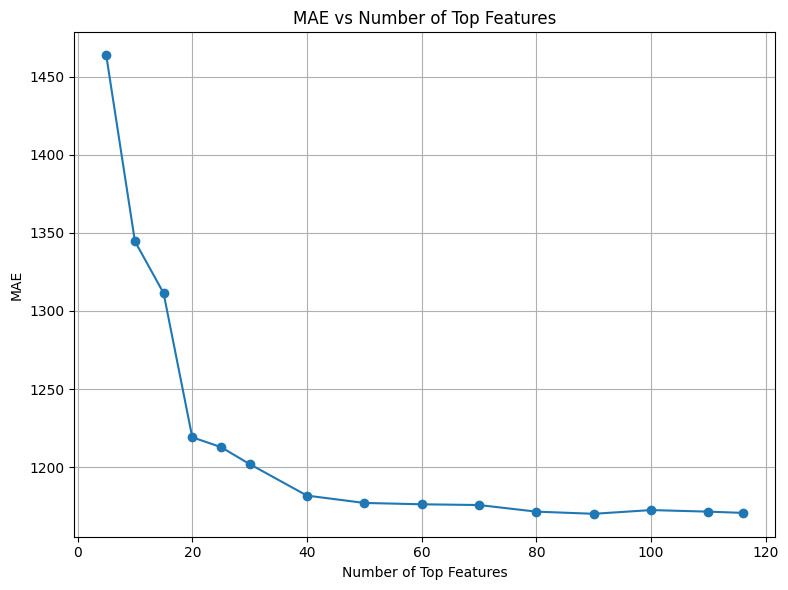


Optimal number of top features (min MAE): 90.0


In [17]:
# Define list of numbers of top features to try
num_features_list = [5, 10, 15, 20, 25, 30, 40, 50, 60, 70, 80, 90, 100, 110, 116]

results = []

for n in num_features_list:
    # Select top n features
    top_n_features = feat_importances.sort_values(ascending=False).head(n).index.tolist()
    X_top_n = X[top_n_features]

    # Train/test split
    X_train_n, X_test_n, y_train_n, y_test_n = train_test_split(
        X_top_n, y, test_size=0.2, random_state=42
    )

    # Define and train XGBoost model
    model_n = XGBRegressor(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_lambda=1,
        random_state=42,
        objective='reg:squarederror',
        eval_metric='mae'
    )

    model_n.fit(
        X_train_n, y_train_n,
        eval_set=[(X_train_n, y_train_n), (X_test_n, y_test_n)],
        verbose=False
    )

    # Predict and evaluate
    y_pred_n = model_n.predict(X_test_n)
    mae_n = mean_absolute_error(y_test_n, y_pred_n)
    rmse_n = np.sqrt(mean_squared_error(y_test_n, y_pred_n))

    results.append({'num_features': n, 'MAE': mae_n, 'RMSE': rmse_n})
    print(f"Top {n} features -> MAE: {mae_n:.4f}, RMSE: {rmse_n:.4f}")

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Plot MAE vs number of features
plt.figure(figsize=(8,6))
plt.plot(results_df['num_features'], results_df['MAE'], marker='o')
plt.title('MAE vs Number of Top Features')
plt.xlabel('Number of Top Features')
plt.ylabel('MAE')
plt.grid(True)
plt.tight_layout()
plt.show()

# Automatically find the optimal number of features (minimum MAE)
best_row = results_df.loc[results_df['MAE'].idxmin()]
best_n = best_row['num_features']
print(f"\nOptimal number of top features (min MAE): {best_n}")

In [19]:
# Retrain final model using optimal top features
top_features_optimal = feat_importances.sort_values(ascending=False).head(int(best_n)).index.tolist()
X_top_opt = X[top_features_optimal]
X_train_opt, X_test_opt, y_train_opt, y_test_opt = train_test_split(
    X_top_opt, y, test_size=0.2, random_state=42
)

final_model = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1,
    random_state=42,
    objective='reg:squarederror',
    eval_metric='mae'
)

final_model.fit(
    X_train_opt, y_train_opt,
    eval_set=[(X_train_opt, y_train_opt), (X_test_opt, y_test_opt)],
    verbose=False
)

# Evaluate final model
y_pred_opt = final_model.predict(X_test_opt)
rmse_opt = np.sqrt(mean_squared_error(y_test_opt, y_pred_opt))
mae_opt = mean_absolute_error(y_test_opt, y_pred_opt)

print(f"\nFinal Model (Optimal Top {best_n} Features):")
print(f"MAE:  {mae_opt:.4f}")
print(f"RMSE: {rmse_opt:.4f}")


Final Model (Optimal Top 90.0 Features):
MAE:  1170.2282
RMSE: 1838.7705


In [20]:
# Tuning hyperparameters to further optimize model
X_train, X_test, y_train, y_test = train_test_split(
    X_top_opt, y, test_size=0.2, random_state=42
)

# Grid Search for Hyperparameter Tuning
param_grid = {
    "n_estimators": [300, 500, 700],
    "learning_rate": [0.03, 0.05],
    "max_depth": [4, 6, 8],
    "reg_lambda": [1, 2, 5]
}

base_model = XGBRegressor(
    objective='reg:squarederror',
    eval_metric='mae',
    random_state=42
)

grid = GridSearchCV(
    estimator=base_model,
    param_grid=param_grid,
    scoring='neg_mean_absolute_error',
    cv=3,
    n_jobs=-1,
    verbose=2
)

print("Running Grid Search...")
grid.fit(X_train, y_train)

print("\nBest Parameters Found:")
print(grid.best_params_)

# Fit Final Model Using Best Hyperparameters
final_model = grid.best_estimator_

final_model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=False
)

# Evaluate Final Model
y_pred = final_model.predict(X_test)

rmse_opt = np.sqrt(mean_squared_error(y_test, y_pred))
mae_opt = mean_absolute_error(y_test, y_pred)

print("\nFinal Optimized Model Performance:")
print(f"MAE:  {mae_opt:.4f}")
print(f"RMSE: {rmse_opt:.4f}")


Running Grid Search...
Fitting 3 folds for each of 54 candidates, totalling 162 fits

Best Parameters Found:
{'learning_rate': 0.03, 'max_depth': 8, 'n_estimators': 700, 'reg_lambda': 5}

Final Optimized Model Performance:
MAE:  1170.0401
RMSE: 1834.2025
